# Web Scraping Indeed Data Science Salaries

The goal of the following project was to acquire Indeed.com job listings, discover what I could about data scientist salaries from the job listings that did include salary data, and then predict whether salaries that did not include listings were above or below the median salary.

First, I imported all necessary libraries.

In [1]:
# libraries to import

# related to webscraping - to acquire data
import requests
import bs4
from bs4 import BeautifulSoup

# for working with and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for modeling
from sklearn.cross_validation import cross_val_score, StratifiedKFold , train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cleaning up the notebook
import warnings
warnings.filterwarnings('ignore')

Next, I wrote a scraper to obtain job postings for data scientist positions from several different markets.

In [2]:
# string of the indeed.com URL we want to search across cities
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

max_results_per_city = 1000

# each result is a set of 10 job listings from one page
results = []
# results city allows cleaner analysis of jobs by location later - what city was searched for?
result_city = []

# loop through set of cities to get job postings
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Boston', 'San+Jose',
    'San+Diego','San+Antonio','Portland', 'Phoenix', 'Denver', 'Houston', 'Washington+DC']):
        for start in range(0, max_results_per_city, 10):
        # Grab the results from the request
            url = url_template.format(city, start)
            job = requests.get(url)
        # Append to the full set of results
            b = BeautifulSoup(job.text)
            results.append(b)
            result_city.append(city)
            pass

The cell below creates an empty dataframe with columns for all the relevant information that I need, and then loops through the scraped results to add each job to the dataframe.

In [3]:
# create empty dataframe
indeed = pd.DataFrame(columns = ['title','location','search_city','company','salary'])

# loop through results list to extract information
for i in results:
    indx = results.index(i)
    for job in i.find_all('div', {'class' : ' row result'}):
        title = job.find('a', {'class':'turnstileLink'}).text
        location = job.find('span', {'class': 'location'}).text
        search_city = result_city[indx]
        try:
            company = job.find('span', {'class' : 'company'}).text.strip()
        except:
            company = 'NA'
        salary = job.find('nobr')
        # add result to end of dataframe
        indeed.loc[len(indeed)]=[title, location, search_city, company, salary]

Below creates a dataframe for all jobs without salaries, then drops duplicate records from that dataframe.

In [4]:
## Extracting all fields with missing salaries for analysis and estimation later

indeed.salary = indeed.salary.astype(str)
indeed_missing = indeed[indeed['salary'] == 'None']

## Drop duplicate scraped records
indeed_missing[['title','location','company','salary']].drop_duplicates(inplace = True)

Below creates a dataframe with only jobs that list annual salaries, then strips out all extra items from the salary string aside from the salary numbers and a '-' indicating if there is a salary range.

The second step removes the '+' from the cities that were searched for.

In [5]:
## Getting only annual salaries, stripping all information out aside from numbers and dash to mark range

indeed_year = indeed[indeed['salary'].str.contains("a year", na=False)]
indeed_year.salary = indeed_year.salary.replace('[/$<nobraye>,]', '', regex = True)

indeed_year.search_city = indeed_year.search_city.replace('+', ' ', regex = True)

The function below gets the mean of the two salaries if there is a range, and converts to a float if there is only one listed. The function is then applied to the dataframe, replacing the original salary.

In [6]:
## function to get average salaries when applicable
## try to split on dash, get mean

def sal_split(i):
    try:
        splt = i.split(' - ',1)
        low = float(splt[0])
        high = float(splt[1])
        return (low + high)/2
    except:
        return float(i)
    
## apply above function to all salaries in df
indeed_year['salary'] = indeed_year['salary'].apply(sal_split)

## dropping dupes
indeed_year[['title','location','company','salary']].drop_duplicates(inplace = True)

Export file to csv - will not run this cell, and will instead use the originally scraped listings.

``` python
indeed_year.to_csv('indeed.csv', encoding='utf-8')
```

### Begin process for model building below

We need to calculate median salary to determine if listing with a salary is above or below the median. We are making this into a classification problem rather than a regression problem, since salaries can fluctuate and we do not have a very large sample of jobs to work with.

In [7]:
## Importing dataset of salaries that was previously saved
df = pd.read_csv('indeed.csv', index_col = 0)

## Found 303 records with salaries
print df.shape

(303, 5)


In [8]:
## calculate median
## lambda applies a 1 if salary is above median, 0 if below
med = np.median(df.salary)
print "The median salary is", med
df['high_low'] = df['salary'].map(lambda x: 1 if x > med else 0)

The median salary is 108702.5


The two graphs below show that San Jose and San Francisco have the highest mean salaries, while our dataset has the most job listings with salaries from New York.

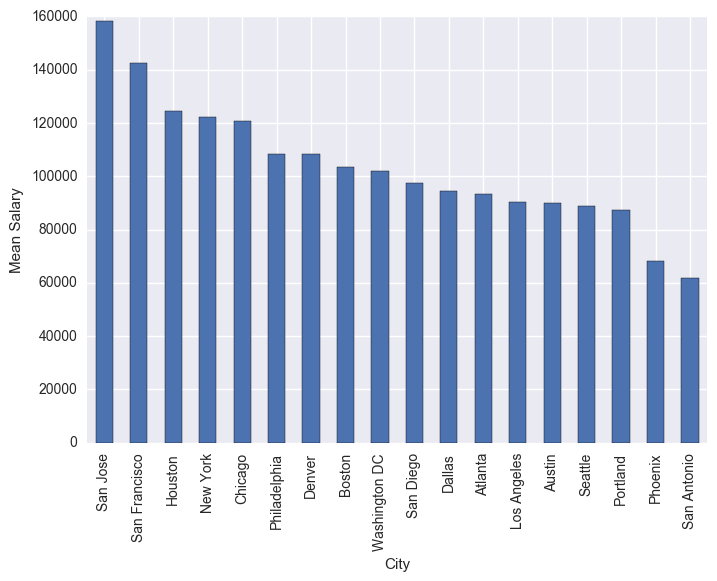

In [9]:
df.groupby('search_city').salary.mean().sort_values(ascending = False).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Mean Salary')
plt.show()

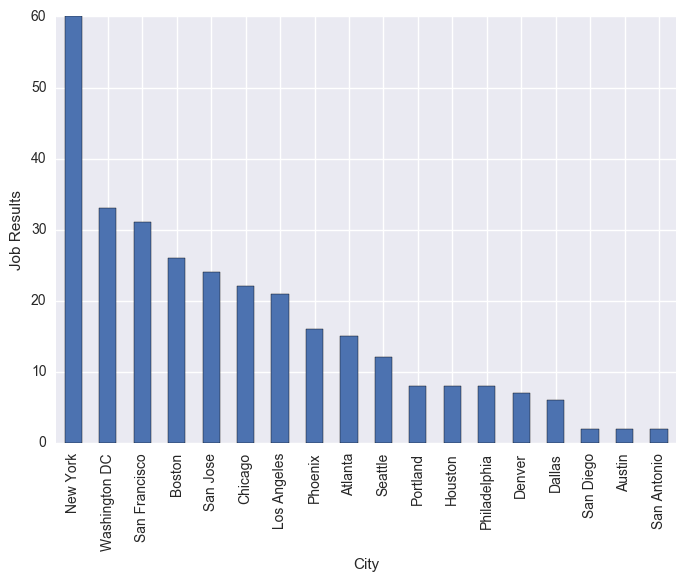

In [10]:
df.search_city.value_counts().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Job Results')
plt.show()

## The model is created below.

I tested several different classification methods, and several different metrics, but ultimately found that a logistic regression was most accurate, and that using a dummy variable for the search city and a tf-idf vectorizer of the job title with n-grams of 2 words provided the best results. 78.9% of salaries in our test set were correctly predicted using these features with a logistic regression.

In [11]:
## Text analysis of job titles

job_titles = df.title

## Using a count vectorizer to ID all individual words across job titles
## Limit ngrams to pairs of 2 words since titles are shorter
tfv = TfidfVectorizer(lowercase = True, strip_accents = 'unicode', ngram_range=(2,2), stop_words = 'english')
tfv_title = tfv.fit_transform(job_titles).todense()


# create dataframe on count vectorized data
title_counts = pd.DataFrame(tfv_title, columns = tfv.get_feature_names())

In [12]:
random_state = 43
X = pd.concat([pd.get_dummies(df['search_city'], drop_first = True).reset_index(), title_counts.reset_index()], axis = 1)
X.drop('index', axis = 1, inplace = True)
y = df['high_low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

In [13]:
logit = LogisticRegression(random_state = random_state)

logit_fit = logit.fit(X_train, y_train)
logit_y_pred = logit.predict(X_test)

print classification_report(y_test, logit_y_pred, target_names=['Low Salary', 'High Salary'])
print confusion_matrix(y_test, logit_y_pred)
print accuracy_score(y_test, logit_y_pred)

             precision    recall  f1-score   support

 Low Salary       0.79      0.82      0.80        40
High Salary       0.79      0.75      0.77        36

avg / total       0.79      0.79      0.79        76

[[33  7]
 [ 9 27]]
0.789473684211


In [15]:
coefs = logit_fit.coef_[0]
names = X.columns

print "Features sorted by their logistic regression coefficients:"
print sorted(zip(map(lambda x: round(x, 4), coefs), names), 
             reverse=True)

Features sorted by their logistic regression coefficients:
[(1.3831, 'San Jose'), (1.3705, u'quantitative analyst'), (1.3575, 'San Francisco'), (1.1074, u'machine learning'), (1.0704, u'senior data'), (1.0361, u'data scientist'), (0.9986, u'quantitative research'), (0.9146, u'data engineer'), (0.91, u'multiple vacancies'), (0.91, u'analyst multiple'), (0.8576, u'data architect'), (0.7954, u'director data'), (0.7136, u'learning engineer'), (0.7103, u'risk analyst'), (0.7103, u'quantitative risk'), (0.692, u'data science'), (0.6565, u'software engineer'), (0.6256, u'lead data'), (0.5902, 'Philadelphia'), (0.4971, u'supervisory statistician'), (0.4554, u'scientist machine'), (0.4402, u'big data'), (0.4184, u'analyst manager'), (0.3997, u'scientist fraud'), (0.3994, 'New York'), (0.3889, 'Chicago'), (0.3712, u'learning researcher'), (0.3472, u'government enterprise'), (0.3472, u'enterprise architect'), (0.3317, u'intelligence scientist'), (0.3317, u'business intelligence'), (0.3284, u'svp 

The search locations San Jose and San Francisco were the most indicative of a salary being high paying above the median, while the word pairs 'quantitative analyst' and 'machine learning' in the job title were most indicative of a high paying salary.

Phoenix, San Antonio, Portland, and Los Angeles had similar negative coefficients, indicating that they have about equal weight in determining that a job will have a lower paying salary below the median. The word pairs 'data analyst' and 'research analyst' were the most indicative of a lower paying salary.

## Missing Salary Predictions

Below, we will predict if the remaining job postings that did not list salaries will be low or high paying using the above model. The data will need to be transformed so that the search location is a dummy variable, and the job titles are converted using the tf-idf vectorizer fit above.

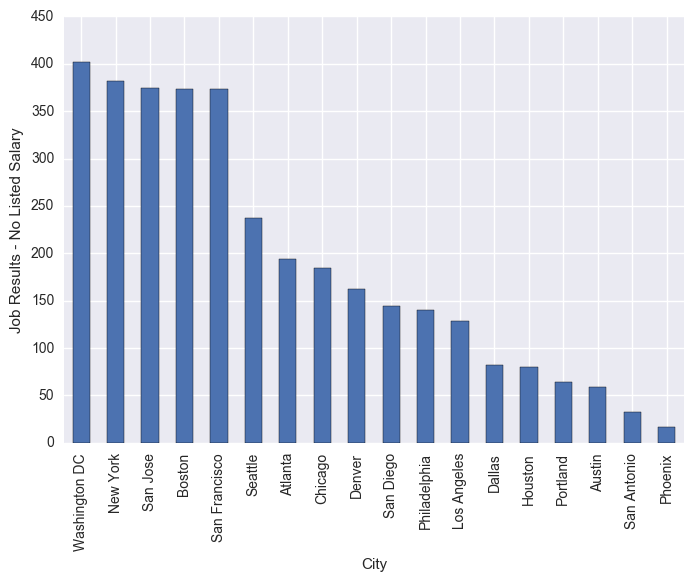

In [31]:
indeed_missing.search_city.value_counts().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Job Results - No Listed Salary')
plt.show()

In [32]:
print("There are {} total job postings with missing salaries".format(len(indeed_missing)))

There are 3428 total job postings with missing salaries


Transforming job listings so they can be predicted as high or low paying...

In [33]:
## Count Vectorizing missing salary job titles
## Will use same words from the fit count vectorizer from our training data to assist in classification

missing_salary_titles = indeed_missing.title
missing_title_counts = pd.DataFrame(tfv.transform(missing_salary_titles).todense(), columns=tfv.get_feature_names())

## Get dummies for job location to allow it to be predicted

miss_city_dum = pd.get_dummies(indeed_missing['search_city'], drop_first = True)
miss_city_dum.reset_index(inplace = True)

## Combine two dfs

missing_sals = pd.concat([miss_city_dum, missing_title_counts], axis = 1)
missing_sals.drop('index', axis = 1, inplace = True)

In [34]:
logit_title_pred = logit_fit.predict(missing_sals)

indeed_missing['high_low'] = logit_title_pred

print(indeed_missing.head())

                                        title  \
0                              Data Scientist   
1                            Research Analyst   
2  Data Scientist (Corporate Experience Must)   
3                            Research Analyst   
4                               Data Engineer   

                            location search_city  \
0  Houston, TX 77002 (Downtown area)     Houston   
1                        Houston, TX     Houston   
2                        Houston, TX     Houston   
3                        Houston, TX     Houston   
4  Houston, TX 77002 (Downtown area)     Houston   

                              company salary  high_low  
0                    General Electric   None         1  
1                 KPRC - TV Channel 2   None         0  
2  Genpact headstrong capital markets   None         1  
3                Pennwell Corporation   None         0  
4               The Talance Group, LP   None         1  


In [42]:
## Aggregating information by city to plot

indeed_missing_agg = pd.concat([indeed_missing.groupby('search_city').sum(), 
                                pd.DataFrame(indeed_missing.groupby('search_city').title.count())], axis = 1)

## Getting percent of jobs that are high paying by city

indeed_missing_agg['high_pct'] = indeed_missing_agg.high_low / indeed_missing_agg.title

indeed_missing_agg.head()

,high_low,title,high_pct
search_city,,,
Atlanta,47,194,0.242268
Austin,26,59,0.440678
Boston,94,373,0.252011
Chicago,68,184,0.369565
Dallas,24,82,0.292683


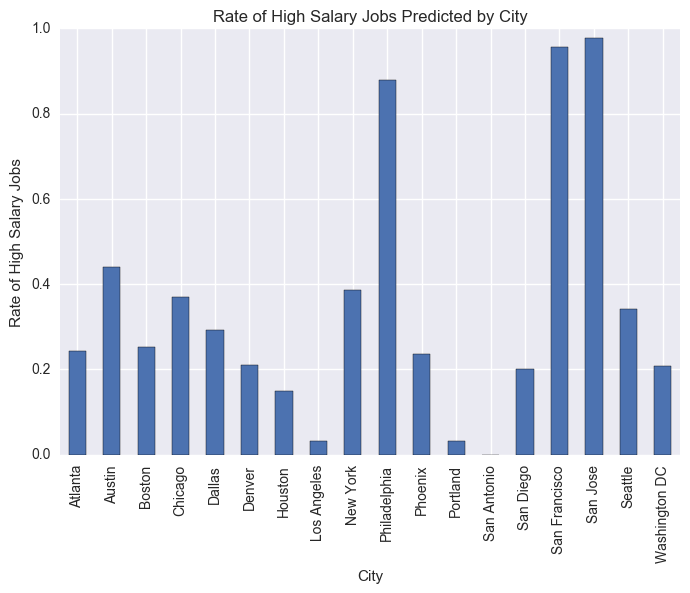

In [43]:
indeed_missing_agg.high_pct.plot.bar()
plt.xlabel('City')
plt.ylabel('Rate of High Salary Jobs')
plt.title('Rate of High Salary Jobs Predicted by City')
plt.show()

## Summary

Using the model created, most jobs in San Jose, San Francisco, and Philadelphia are expected to pay above the median salary for all data scientist related jobs in these markets. Most jobs in other cities are expected to be below the median salary for these jobs.